In [1]:
from pyspark import SparkContext

sc = SparkContext(master=master_url)

In [2]:
!pip install pandas

In [3]:
!pip install scipy

In [4]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

%pylab inline

import pandas as pd
import datetime as dt

from scipy.io import loadmat,savemat,whosmat

from string import split
from collections import Counter
import re
import numpy as np
from numpy import shape

from glob import glob



Populating the interactive namespace from numpy and matplotlib


### Format of matlab files

The name format is as follows:

|Name | site name | Recording number | Species | Type of file | Data Cleaning iteration |
|-|-----------|------------------|---------|--------------|-------------------------|
|**Field name in code** | site | rec_no | species | fields | no |
| | DT, GC, MC | 01,02,.. | Cuviers and Gerveis | **TPWS:** full data (waveforms) | no number == 1 |
| |            |          |                     | **MD:** click belongs to other species | |
| |            |          |                     | **FD:** click appearing in other species belongs here | |


### Format of cvs files
|field name     | Description               | Data Type
|---------------|---------------------------|--------------
|0: time        | time of click             | string in datetime format `%Y-%m-%d %H:%M:%S.%f`
|1: species		| Initial species classification	        | 'str'
|2: site		| name of site		        | 'str'
|3: rec_no		| recording number		    | 'str'
|4: bout_i		| bout number		        | numpy.int64
|5: peak2peak	| peak to peak magnitude    | 			numpy.float64
|6: MSN	        |	wave form |		 an array of length 202
|208: MSP		|	spectra |	 an array of length 101  
|309: TPWS1		| 1 if click appears in TPWS1	| 	bool
|310: MD1		|	--- " ---	in MD1|	bool
|311: FD1	    |	--- " ---	in FD1|	bool
|312: TPWS2		| 1 if click appears in TPWS2	| 	bool
|313: MD2		|	--- " ---	in MD2|	bool
|314: FD2	    |	--- " ---	in FD2|	bool
|315: TPWS3		| 1 if click appears in TPWS3	| 	bool
|316: MD3		|	--- " ---	in MD3|	bool
|317: FD3	    |	--- " ---	in FD3|	bool
total number of fields= 318


In [5]:
%cd /root/ipython/BeakedWhaleClassification/
%run Credentials.ipynb

/root/ipython/BeakedWhaleClassification


In [6]:
s3helper.set_credential(AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY)

In [7]:
s3helper.open_bucket('while-classification')

In [8]:
dirs=[str(a) for a in s3helper.ls_s3('') if '_' in a]
dirs

['DT_Cuviers',
 'DT_Gervais',
 'GC_Cuviers',
 'GC_Gervais',
 'MC_Cuviers',
 'MC_Gervais']

In [9]:
# check avaiable local space
!df

Filesystem           1K-blocks      Used Available Use% Mounted on
/dev/xvda1             8256920   4415148   3757892  55% /
tmpfs                 31420132         0  31420132   0% /dev/shm
/dev/xvdb            154818540  25253940 121700280  18% /mnt


In [10]:
#%%writefile matlab2datenum.py
def matlab2datetime(matlab_datenum):
    try:
        day = dt.datetime.fromordinal(int(matlab_datenum))
        dayfrac = dt.timedelta(days=matlab_datenum%1) - dt.timedelta(days = 366)
        return day + dayfrac
    except:
        return None

def mat2columns(data,label):
    """ load a 2d number array as columns in D 
            data: 2d numpy array
            label: the prefix of the columns (followed by index)
            D: assumed to be an existing dataframe, defined externally.
    """
    for i in range(shape(data)[1]):
        col=label+str(i)
        D[col]=data[:,i]
        columns.append(col)

def mat2packedarrays(data):
    """ represent a 2D array as a list of binary arrays"""
    m,n = data.shape
    L=[]
    for i in range(m):
        L.append(packArray(data[i,:],))
    return L


# %load numpy_pack.py
import numpy as np
"""Code for packing and unpacking a numpy array into a byte array.
   the array is flattened if it is not 1D.
   This is intended to be used as the interface for storing 
   
   This code is intended to be used to store numpy array as fields in a dataframe and then store the 
   dataframes in a parquet file.
"""

def packArray(a):
    if type(a)!=np.ndarray:
        raise Exception("input to packArray should be numpy.ndarray. It is instead "+str(type(a)))
    return bytearray(a.tobytes())
def unpackArray(x,data_type=np.int16):
    return np.frombuffer(x,dtype=data_type)

pattern=re.compile(r'(\w{2})(\d{2})_([^_]+)_([A-Z]+)(\d*).mat')
def parse_filename(filename):
    match=pattern.search(filename)
    if match:
        site,rec_no,species,fields,no=match.groups()
        if no=='':  # if no iteration number, call it iteration 1.
            no='1'
        return (site,rec_no,species,fields,no)
    else:
        return -1
parse_filename('DT_Cuviers/DT02_Cuviers_FD.mat')

('DT', '02', 'Cuviers', 'FD', '1')

In [11]:
def row2cvs(T,lrow,fmt='%6.4f',date_format='%Y-%m-%d %H:%M:%S.%f'):
    L=[dt.datetime.strftime(T,date_format)]
    for x in lrow:
        #print type(x)
        if type(x)==type('string'):
            L.append(x)
        elif type(x)==np.float64:
            L.append(fmt%x)
        elif type(x)==np.bool_:
            L.append('%1d'%(1*x))
        elif type(x)==numpy.int64:
            L.append(str(x))
        elif type(x)==bytearray:
            L.append(packed2cvs(x))
        else:
            raise Exception('row2cvs error: unrecognized type='+str(type(x)))
    return ','.join(L)+'\n'

def packed2cvs(row, data_type=np.float64,fmt='%6.4f'):
    return ','.join([fmt%x for x in list(unpackArray(row,data_type=data_type))])

In [31]:
#Copy mat files to local directory
pattern=re.compile(r'(\w{2})(\d{2})_([^_]+)_([A-Z]+)(\d*).mat')
for _dir in dirs:
    !mkdir /mnt/whales/$_dir
    List=s3helper.ls_s3(_dir)
    master_key=0
    for _file in List:
        print _dir,_file
        key=parse_filename(_file)
        if key==-1:
            continue
        print key
        s3helper.s3_to_local(_file,'/mnt/whales/'+_file)
#        if master_key==0:
#            master_key=key[:3]
#            print master_key
#        else:
#            if key[:3] != master_key:
                


mkdir: cannot create directory `/mnt/whales/DT_Cuviers': File exists
DT_Cuviers DT_Cuviers/DT01_Cuviers_FD.mat
(u'DT', u'01', u'Cuviers', u'FD', '1')
DT_Cuviers DT_Cuviers/DT01_Cuviers_FD2.mat
(u'DT', u'01', u'Cuviers', u'FD', u'2')
DT_Cuviers DT_Cuviers/DT01_Cuviers_MD.mat
(u'DT', u'01', u'Cuviers', u'MD', '1')
DT_Cuviers DT_Cuviers/DT01_Cuviers_MD2.mat
(u'DT', u'01', u'Cuviers', u'MD', u'2')
DT_Cuviers DT_Cuviers/DT01_Cuviers_TPWS.mat
(u'DT', u'01', u'Cuviers', u'TPWS', '1')
DT_Cuviers DT_Cuviers/DT01_Cuviers_TPWS2.mat
(u'DT', u'01', u'Cuviers', u'TPWS', u'2')
DT_Cuviers DT_Cuviers/DT02_Cuviers_FD.mat
(u'DT', u'02', u'Cuviers', u'FD', '1')
DT_Cuviers DT_Cuviers/DT02_Cuviers_FD2.mat
(u'DT', u'02', u'Cuviers', u'FD', u'2')
DT_Cuviers DT_Cuviers/DT02_Cuviers_MD.mat
(u'DT', u'02', u'Cuviers', u'MD', '1')
DT_Cuviers DT_Cuviers/DT02_Cuviers_MD2.mat
(u'DT', u'02', u'Cuviers', u'MD', u'2')
DT_Cuviers DT_Cuviers/DT02_Cuviers_TPWS.mat
(u'DT', u'02', u'Cuviers', u'TPWS', '1')
DT_Cuviers DT_Cuvi

In [14]:
!ls -l /mnt/whales/* | wc
!df
!du -s -h /mnt/whales/*
#s3helper.s3_to_local('DT_Cuviers/DT04_Cuviers_TPWS2.mat','/mnt/whales/DT_Cuviers/DT04_Cuviers_TPWS2.mat')

    245    2070   15551
Filesystem           1K-blocks      Used Available Use% Mounted on
/dev/xvda1             8256920   4415152   3757888  55% /
tmpfs                 31420132         0  31420132   0% /dev/shm
/dev/xvdb            154818540  25248000 121706220  18% /mnt
12G	/mnt/whales/DT_Cuviers
6.2G	/mnt/whales/DT_Gervais
278M	/mnt/whales/GC_Cuviers
2.0G	/mnt/whales/GC_Gervais
658M	/mnt/whales/MC_Cuviers
2.4G	/mnt/whales/MC_Gervais


In [86]:
from glob import glob
%cd "/mnt/whales"
!mkdir /mnt/whales_CVS

dirs=glob('/mnt/whales/*')
print dirs
for _dir in dirs:
    print _dir
    print '\n','='*50
    List=glob(_dir+"/*.mat")
    Keys = [parse_filename(a) for a in List]
    Master_Keys=list(set([a[:3] for a in Keys]))
    #print 'master keys for ',_dir,'\n',Master_Keys

    # read mat files for one recordings
    for _master in Master_Keys:
        print '\nprocessing','.'.join(_master)
        print '-'*50
        data={}
        for filename in List:
            key=parse_filename(filename)
            if key[:3]!=_master:
                continue
            print 'loading %s into %s'%(filename,key)
            data[key]=loadmat(filename)
            #print '====',key,':'

            for key2 in data[key].keys():
                if key2[:2]=='__':
                    del data[key][key2]
                else:
                    pass
                    #print key2, shape(data[key][key2])
                    
        print '\n read TPWS files into a pandas dataframe'
        
        mdf=None  # mdf is the master data frame into which all of the data is collected.

        # load TPWS files
        for file_key in [k for k in data.keys() if k[:4]==_master[:3]+('TPWS',)]:
            #print file_key

            TPWS=data[file_key]

            D={}
            columns=['time','species','site','rec_no','bout_i','peak2peak','MSN','MSP']
            D['time']=[matlab2datetime(t) for t in TPWS['MTT'][0,:]]
            D['site']=_master[0]
            D['rec_no']=_master[1]
            D['species']=_master[2]
            D['peak2peak']=TPWS['MPP'][0,:]

            D['MSN'] = mat2packedarrays(TPWS['MSN'])
            D['MSP'] = mat2packedarrays(TPWS['MSP'])

            df=pd.DataFrame(D,columns=columns)
            df.index=D['time']
            df=df[columns[1:]]
            if type(mdf)==type(None):
                mdf=df
            else:
                # add rows that do not currently exist in mdf
                df_new=df.select(lambda x: not x in mdf.index)
                mdf=pd.concat([mdf,df_new])
            print 'after adding %s%s'%file_key[-2:],df.shape,mdf.shape
        
        print "\n merge all data items (.mat files) corresponding to site, rec_no and species"

        akeys=[]
        
        #add indicator columns.
        for col in ['TPWS1','MD1','FD1','TPWS2','MD2','FD2','TPWS3','MD3','FD3']:
            mdf[col]=False
        
        for file_key in [k for k in data.keys() if k[:3]==_master[:3]]:

            tbl=data[file_key]
            array_keys=tbl.keys()
            if len(array_keys)==1:
                time_key=array_keys[0]
            else:
                time_key='MTT'


            D2=[matlab2datetime(t) for t in np.ravel(tbl[time_key])]


            if len(D2)==0:
                print file_key,'is empty'
                continue

            S3=pd.Series(data=True,index=D2)
            # Remove from S3 entries with a bad index
            nans=[(a!= None and type(a)!=pd.tslib.NaTType) for a in S3.index]
            S3=S3[nans]
            mdf_key=file_key[-2]+file_key[-1]
            akeys.append(mdf_key)
            if not mdf_key in mdf.columns:
                print 'ERROR: the key %s is not predifined'%mdf_key
            else:
                mdf[mdf_key]=S3
        mdf=mdf.fillna(False)
        print 'after adding all',mdf.shape
        print 'akeys=',akeys
        
        
        print '\n find time gaps (breaks) larger the 1800 seconds = 30 minutes',
        #these time gaps define what is a recording from a single bout of whales.

        mdf=mdf.sort_index()
        times=mdf.index
        deltas=np.array([(times[i+1]-times[i]).total_seconds() for i in range(len(times)-1)])
        bout_i = np.concatenate([[0],np.cumsum(deltas>1800)])

        mdf['bout_i']=bout_i
        print 'found',bout_i[-1],'bouts'
        
        print '\n Exporting dataframe as CVS files'
        No_of_rows_per_file=10000
        cvs_dirname='.'.join(_master)
        !mkdir /mnt/whales_CVS/$cvs_dirname
        %cd /mnt/whales_CVS/$cvs_dirname
        cvs=0
        _len = mdf.shape[0]
        print 'total length=',_len
        _current_bout=-1
        row_count=0
        file_count=1
        for i in range(_len):
            row=mdf.ix[i,:]
            row_count+=1
            # break the file on bout boundry when length is larger than No_of_rows_per_file
            if (row['bout_i']!=_current_bout):
                _current_bout=row['bout_i']
                if cvs!=0 and (row_count >No_of_rows_per_file):  #close file
                    cvs.close()
                    cvs=0
                    print '\r File: %s: Percent processed %5.2f \tbout_no=%d'%(cvs_filename,(i+0.0)/_len*100,_current_bout),
                    s3helper.local_to_s3(cvs_filename,'CVS/'+cvs_dirname+'/'+cvs_filename)
                    #!rm $cvs_filename

                if i<_len-1 and cvs==0:  #not last bout. -- open a new file
                    cvs_filename = cvs_dirname+"."+str(file_count)+'.cvs'
                    cvs=open(cvs_filename,'w')
                    row_count=0
                    file_count+=1

            T=mdf.index[i]
            cvs.write(row2cvs(T,row))
        # clean up
        cvs.close()
        cvs=0
        print '\r File: %s: Percent processed %5.2f \tbout_no=%d'%(cvs_filename,(i+0.0)/_len*100,_current_bout),
        s3helper.local_to_s3(cvs_filename,'CVS/'+cvs_dirname+'/'+cvs_filename)
        #!rm $cvs_filename
        print 'done'
    

/mnt/whales
mkdir: cannot create directory `/mnt/whales_CVS': File exists
['/mnt/whales/MC_Cuviers', '/mnt/whales/DT_Gervais', '/mnt/whales/MC_Gervais', '/mnt/whales/DT_Cuviers', '/mnt/whales/GC_Cuviers', '/mnt/whales/GC_Gervais']
/mnt/whales/MC_Cuviers


processing MC.01.Cuviers
--------------------------------------------------
loading /mnt/whales/MC_Cuviers/MC01_Cuviers_MD1.mat into ('MC', '01', 'Cuviers', 'MD', '1')
loading /mnt/whales/MC_Cuviers/MC01_Cuviers_MD2.mat into ('MC', '01', 'Cuviers', 'MD', '2')
loading /mnt/whales/MC_Cuviers/MC01_Cuviers_TPWS2.mat into ('MC', '01', 'Cuviers', 'TPWS', '2')
loading /mnt/whales/MC_Cuviers/MC01_Cuviers_FD1.mat into ('MC', '01', 'Cuviers', 'FD', '1')
loading /mnt/whales/MC_Cuviers/MC01_Cuviers_FD2.mat into ('MC', '01', 'Cuviers', 'FD', '2')
loading /mnt/whales/MC_Cuviers/MC01_Cuviers_TPWS1.mat into ('MC', '01', 'Cuviers', 'TPWS', '1')

 read TPWS files into a pandas dataframe
after adding TPWS1 (2332, 7) (2332, 7)
after adding TPWS2 (200, 7)

In [87]:
print mdf.columns
mdf.head()

Index([u'species', u'site', u'rec_no', u'bout_i', u'peak2peak', u'MSN', u'MSP',
       u'TPWS1', u'MD1', u'FD1', u'TPWS2', u'MD2', u'FD2', u'TPWS3', u'MD3',
       u'FD3'],
      dtype='object')


,species,site,rec_no,bout_i,peak2peak,MSN,MSP,TPWS1,MD1,FD1,TPWS2,MD2,FD2,TPWS3,MD3,FD3
2011-09-24 08:41:14.999997,Gervais,GC,04,0,52.363928,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[230, 79, 122, 173, 117, 205, 58, 192, 24, 201...",True,True,False,False,False,False,False,False,False
2011-09-24 08:41:15.179879,Gervais,GC,04,0,51.487554,"[224, 160, 144, 99, 108, 195, 12, 192, 192, 16...","[57, 54, 150, 127, 227, 51, 64, 192, 54, 212, ...",True,True,False,False,False,False,False,False,False
2011-09-24 08:41:15.459519,Gervais,GC,04,0,52.342093,"[224, 246, 38, 79, 63, 158, 8, 64, 128, 215, 1...","[98, 248, 2, 234, 102, 160, 58, 192, 93, 67, 3...",True,True,False,False,False,False,False,False,False
2011-09-24 08:41:15.743666,Gervais,GC,04,0,51.034950,"[192, 65, 130, 171, 150, 214, 251, 191, 224, 6...","[74, 147, 254, 67, 189, 147, 61, 192, 118, 98,...",True,True,False,False,False,False,False,False,False
2011-09-24 08:41:23.200405,Gervais,GC,04,0,52.788663,"[104, 249, 163, 157, 52, 216, 234, 191, 147, 5...","[140, 59, 107, 66, 4, 202, 71, 192, 189, 211, ...",True,True,False,False,False,False,False,False,False


In [88]:
! wc /mnt/whales_CVS/*/*

      10957       21914    28240917 /mnt/whales_CVS/DT.01.Cuviers/DT.01.Cuviers.10.cvs
      11691       23382    30325964 /mnt/whales_CVS/DT.01.Cuviers/DT.01.Cuviers.11.cvs
      10934       21868    28216304 /mnt/whales_CVS/DT.01.Cuviers/DT.01.Cuviers.12.cvs
      10600       21200    27627479 /mnt/whales_CVS/DT.01.Cuviers/DT.01.Cuviers.13.cvs
      11303       22606    29293718 /mnt/whales_CVS/DT.01.Cuviers/DT.01.Cuviers.14.cvs
      13553       27106    35160719 /mnt/whales_CVS/DT.01.Cuviers/DT.01.Cuviers.15.cvs
      10256       20512    26283569 /mnt/whales_CVS/DT.01.Cuviers/DT.01.Cuviers.16.cvs
      10348       20696    27017861 /mnt/whales_CVS/DT.01.Cuviers/DT.01.Cuviers.17.cvs
      10065       20130    25641677 /mnt/whales_CVS/DT.01.Cuviers/DT.01.Cuviers.18.cvs
      10929       21858    28301586 /mnt/whales_CVS/DT.01.Cuviers/DT.01.Cuviers.19.cvs
      10092       20184    26169314 /mnt/whales_CVS/DT.01.Cuviers/DT.01.Cuviers.1.cvs
      10222       20444    26406925 /mnt/wha

In [39]:
!head /mnt/whales_CVS/MC.01.Cuviers/MC.01.Cuviers.3.cvs


2010-07-22 04:46:33.921485,MC,01,Cuviers,55.3605,2.3591,0.1043,-9.4285,-19.6007,-6.8449,-13.7740,-2.6250,-1.9845,6.6426,-3.3865,15.4192,11.6874,-6.5932,4.2953,0.4884,11.9694,-10.8529,-5.2546,7.1401,-4.0363,-10.8617,1.7242,2.8809,7.0684,-6.2683,14.0890,-3.0687,-12.7789,-5.6548,-7.3986,-3.6064,-9.7164,13.0032,-1.7491,1.6180,13.1518,8.5968,9.8916,1.0491,-12.6100,-5.9121,-3.5760,-5.7831,2.7590,-2.7495,2.9428,0.0029,-9.8106,8.9386,1.3040,3.1152,5.5703,-3.9345,-2.6546,-1.8713,-7.7903,-4.7833,1.6478,1.9398,-0.0717,0.7902,-1.2883,3.7566,4.6366,0.5179,-2.5389,2.5444,6.7647,1.4548,-4.0922,-6.2444,3.7721,-6.3377,6.2311,-0.2362,-9.8909,-8.5471,-6.8756,-4.2356,-1.3359,8.0391,-0.6003,5.0562,13.1089,2.4263,3.7287,0.1844,6.5359,5.3100,-7.0670,-3.0838,-9.0730,-2.2310,-8.1886,-17.9417,0.1574,0.4975,0.1183,34.6197,22.8130,-252.0801,262.1920,167.1523,-323.9770,148.3297,-1.5201,-6.3701,-59.1952,15.2577,12.8085,-49.3236,11.4182,19.8157,27.5691,-37.1840,47.7597,-6.5176,-11.7932,-16.4352,29.1922,-11.7931,8.44

In [23]:
shape(TPWS['MSN']),shape(TPWS['MSP'])

((274223, 202), (274223, 101))

In [61]:
akeys

['TPWS2', 'FD2', 'MD2', 'MD1', 'FD1', 'TPWS1']

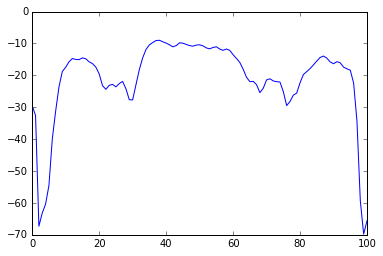

In [91]:
plot(unpackArray(mdf['MSP'][3],data_type=np.float64))

In [27]:
mdf=mdf.sort_index()
mdf[[u'site', u'rec_no', u'species', u'peak2peak']+akeys].head(10)

,site,rec_no,species,peak2peak,FD2,TPWS2,TPWS1,FD1,MD1
2010-08-09 07:01:15.000002,DT,01,Cuviers,45.985810,False,False,True,True,False
2010-08-09 07:02:29.999998,DT,01,Cuviers,44.843157,False,False,True,True,False
2010-08-09 07:03:45.000003,DT,01,Cuviers,45.863097,False,False,True,True,False
2010-08-09 07:05:11.523171,DT,01,Cuviers,54.203887,False,False,True,True,False
2010-08-09 07:06:27.096821,DT,01,Cuviers,53.953768,False,False,True,True,False
2010-08-09 07:06:32.772006,DT,01,Cuviers,49.842384,False,False,True,True,False
2010-08-09 07:06:33.616731,DT,01,Cuviers,49.010330,False,False,True,True,False
2010-08-09 07:06:34.485807,DT,01,Cuviers,47.118755,False,False,True,True,False
2010-08-09 07:06:40.280545,DT,01,Cuviers,48.309630,False,False,True,True,False
2010-08-09 07:06:40.964398,DT,01,Cuviers,51.501142,False,False,True,True,False


In [28]:
#find time gaps (breaks) larger the 1800 seconds = 30 minutes
#these time gaps define what is a recording from a single bout of whales.

times=mdf.index

deltas=np.array([(times[i+1]-times[i]).total_seconds() for i in range(len(times)-1)])

bout_i = np.concatenate([[0],np.cumsum(deltas>1800)])

mdf['bout_i']=bout_i

In [29]:
Flags = pd.DataFrame(mdf[akeys])
Flags['ones']=1
Flags.groupby(akeys).count()

ones
FD2   TPWS2 TPWS1 FD1   MD1          
False False True  False True    69939
                  True  False    7786
                        True       20
      True  False False False     723
            True  False False  195140
                        True      362
                  True  False      54
True  True  True  False False     922

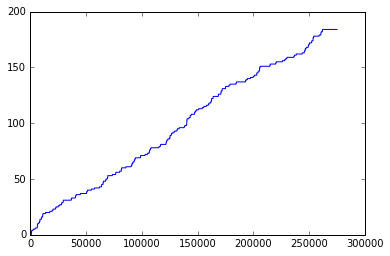

In [30]:
plot (bout_i);

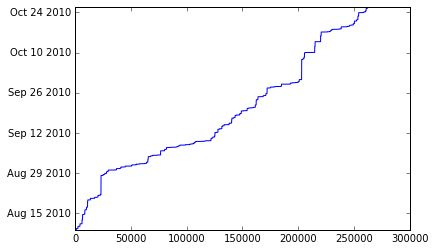

In [31]:
plot(times);

In [32]:
mdf.columns

Index([u'site', u'rec_no', u'species', u'peak2peak', u'MSN', u'MSP', u'FD2',
       u'TPWS2', u'TPWS1', u'FD1', u'MD1', u'bout_i'],
      dtype='object')

In [33]:
mdf=mdf[[u'site', u'rec_no', u'bout_i', u'species', u'peak2peak','MSN','MSP']+akeys]
mdf.head()

,site,rec_no,bout_i,species,peak2peak,MSN,MSP,FD2,TPWS2,TPWS1,FD1,MD1
2010-08-09 07:01:15.000002,DT,01,0,Cuviers,45.985810,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[180, 196, 7, 138, 165, 28, 65, 192, 18, 240, ...",False,False,True,True,False
2010-08-09 07:02:29.999998,DT,01,0,Cuviers,44.843157,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[84, 0, 16, 72, 93, 160, 65, 192, 118, 53, 42,...",False,False,True,True,False
2010-08-09 07:03:45.000003,DT,01,0,Cuviers,45.863097,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[67, 227, 115, 122, 1, 223, 64, 192, 235, 234,...",False,False,True,True,False
2010-08-09 07:05:11.523171,DT,01,0,Cuviers,54.203887,"[240, 213, 200, 89, 189, 43, 16, 192, 0, 226, ...","[44, 106, 239, 80, 161, 102, 65, 192, 96, 105,...",False,False,True,True,False
2010-08-09 07:06:27.096821,DT,01,0,Cuviers,53.953768,"[64, 95, 23, 103, 183, 17, 21, 192, 224, 168, ...","[42, 38, 133, 226, 139, 135, 66, 192, 136, 97,...",False,False,True,True,False


In [34]:
def packed2cvs(row, data_type=np.float64,fmt='%6.4f'):
    return ','.join([fmt%x for x in list(unpackArray(row,data_type=data_type))])
packed2cvs(mdf['MSP'][1])

'-35.2528,-35.0435,-46.4771,-49.8702,-50.1851,-48.7973,-33.8817,-24.9540,-19.3585,-16.5317,-15.8172,-16.3975,-17.3719,-17.7369,-17.6556,-17.9082,-18.2148,-18.8320,-19.5688,-19.1760,-18.8469,-20.0967,-20.9053,-20.6163,-21.8672,-22.1504,-22.2318,-22.8896,-21.9784,-22.3762,-23.8167,-23.0124,-21.6222,-21.8216,-24.1648,-27.8420,-27.2391,-24.8876,-24.0436,-24.3730,-24.8900,-25.3223,-26.1830,-25.6344,-24.5404,-25.2670,-27.4257,-30.4422,-31.8927,-29.3916,-27.2991,-25.7257,-25.6982,-27.3833,-28.5848,-29.2403,-31.4937,-31.5888,-28.6602,-26.8062,-26.2541,-26.7075,-27.3277,-27.8395,-29.2882,-30.8081,-29.3463,-26.1469,-24.2931,-24.1431,-25.5900,-29.4158,-31.8303,-28.2881,-27.4818,-28.9584,-32.5434,-36.0896,-28.4966,-25.5702,-24.3769,-24.5974,-28.1669,-35.0698,-35.3643,-30.9863,-27.6685,-26.5005,-25.9734,-25.7509,-26.8151,-30.7129,-35.8730,-32.2192,-31.2438,-33.3672,-38.0414,-46.4163,-63.5005,-74.7820,-70.9636'

In [35]:
mdf.columns

Index([u'site', u'rec_no', u'bout_i', u'species', u'peak2peak', u'MSN', u'MSP',
       u'FD2', u'TPWS2', u'TPWS1', u'FD1', u'MD1'],
      dtype='object')

In [37]:
row=mdf.ix[0,:]
lrow=list(row)
#print row
pos=1
print "0: time of click"
for i in range(len(row)):
    a=row[i]
    name=row.index[i]
    if type(row[i])!=bytearray:
        print ' %5d: %s\t\t\t\t%s'%(pos,name,str(type(a)))
        pos+=1
    else:
        print " %5d: %s\t\t\t\t an array of length %d"%(pos,name,len(a)/8)
        pos+=len(a)/8

print "total number of fields=",pos

0: time of click
     1: site				<type 'str'>
     2: rec_no				<type 'str'>
     3: bout_i				<type 'numpy.int64'>
     4: species				<type 'str'>
     5: peak2peak				<type 'numpy.float64'>
     6: MSN				 an array of length 202
   208: MSP				 an array of length 101
   309: FD2				<type 'numpy.bool_'>
   310: TPWS2				<type 'numpy.bool_'>
   311: TPWS1				<type 'numpy.bool_'>
   312: FD1				<type 'numpy.bool_'>
   313: MD1				<type 'numpy.bool_'>
total number of fields= 314


In [61]:
cvs_dirname='.'.join(master_key)
cvs_dirname

'DT.01.Cuviers'

In [81]:
cvs=0
_len = mdf.shape[0]
print 'total length=',_len
_current_bout=-1
for i in range(_len):
    row=mdf.ix[i,:]
    if row['bout_i']!=_current_bout:
        if cvs!=0:
            cvs.close()
            s3helper.local_to_s3(cvs_filename,'CVS/'+cvs_dirname+'/'+cvs_filename)
            !rm $cvs_filename

        _current_bout=row['bout_i']
        cvs_filename = cvs_dirname+"."+str(_current_bout)+'.cvs'
        # print cvs_filename,'CVS/'+cvs_dirname+'/'+cvs_filename
        print '\r Percent processed %5.2f \tbout_no=%d'%((i+0.0)/_len*100,_current_bout),
        cvs=open(cvs_filename,'w')
                                                           
    T=mdf.index[i]
    cvs.write(row2cvs(T,row))
cvs.close()
s3helper.local_to_s3(cvs_filename,'CVS/'+cvs_dirname+'/'+cvs_filename)
print 'done'

total length= 274946
 Percent processed 95.24 	bout_no=184 done


In [82]:
!pwd
print cvs_filename
!ls -l *.cvs

/mnt/whales/DT_Cuviers
DT.01.Cuviers.184.cvs
-rw-r--r-- 1 root root  2629774 Aug 28 21:55 DT.01.Cuviers.0.cvs
-rw-r--r-- 1 root root    99611 Aug 28 21:56 DT.01.Cuviers.100.cvs
-rw-r--r-- 1 root root    79269 Aug 28 21:56 DT.01.Cuviers.101.cvs
-rw-r--r-- 1 root root   172148 Aug 28 21:56 DT.01.Cuviers.102.cvs
-rw-r--r-- 1 root root   389600 Aug 28 21:56 DT.01.Cuviers.103.cvs
-rw-r--r-- 1 root root  4330797 Aug 28 21:56 DT.01.Cuviers.104.cvs
-rw-r--r-- 1 root root  2899322 Aug 28 21:56 DT.01.Cuviers.105.cvs
-rw-r--r-- 1 root root   224744 Aug 28 21:56 DT.01.Cuviers.106.cvs
-rw-r--r-- 1 root root  2190863 Aug 28 21:56 DT.01.Cuviers.107.cvs
-rw-r--r-- 1 root root  7298495 Aug 28 21:56 DT.01.Cuviers.108.cvs
-rw-r--r-- 1 root root   805064 Aug 28 21:56 DT.01.Cuviers.109.cvs
-rw-r--r-- 1 root root  2734112 Aug 28 21:55 DT.01.Cuviers.10.cvs
-rw-r--r-- 1 root root  1290544 Aug 28 21:56 DT.01.Cuviers.110.cvs
-rw-r--r-- 1 root root  2443396 Aug 28 21:56 DT.01.Cuviers.111.cvs
-rw-r--r-- 1 root ro

In [67]:
print cvs_filename,'CVS/'+cvs_dirname+'/'+cvs_filename
s3helper.local_to_s3(cvs_filename,'CVS/'+cvs_dirname+'/'+cvs_filename)

DT.01.Cuviers.1.cvs CVS/DT.01.Cuviers/DT.01.Cuviers.1.cvs


Exception: File does not exist.

In [63]:
!rm DT.01.Cuviers.*

In [71]:
s3helper.ls_s3('CVS')

[u'CVS/DT.01.Cuviers']

In [53]:
!wc *


         0          0          0 DT.01.Cuviers.cvs
      1011       2022    2629774 DT.01.Cuviers.cvs0.cvs
        39         78      99611 DT.01.Cuviers.cvs100.cvs
        31         62      79269 DT.01.Cuviers.cvs101.cvs
        67        134     172148 DT.01.Cuviers.cvs102.cvs
       149        298     389600 DT.01.Cuviers.cvs103.cvs
      1657       3314    4330797 DT.01.Cuviers.cvs104.cvs
      1125       2250    2899322 DT.01.Cuviers.cvs105.cvs
        88        176     224744 DT.01.Cuviers.cvs106.cvs
       849       1698    2190863 DT.01.Cuviers.cvs107.cvs
      2874       5748    7298495 DT.01.Cuviers.cvs108.cvs
       315        630     805064 DT.01.Cuviers.cvs109.cvs
      1053       2106    2734112 DT.01.Cuviers.cvs10.cvs
       501       1002    1290544 DT.01.Cuviers.cvs110.cvs
       950       1900    2443396 DT.01.Cuviers.cvs111.cvs
      1995       3990    5240866 DT.01.Cuviers.cvs112.cvs
      3225       6450    8361976 DT.01.Cuviers.cvs113.cvs
      1435       2870   

In [54]:
s3helper.local_to_s3('DT.01.Cuviers.cvs101.cvs','CVS/DT.01.Cuviers/DT.01.Cuviers.cvs101.cvs')

In [68]:
        for col in ['TPWS1','MD1','FD1','TPWS2','MD2','FD2','TPWS3','MD3','FD3']:
            mdf[col]=False
        
 

In [69]:
mdf.columns

Index([u'site', u'rec_no', u'species', u'peak2peak', u'MSN', u'MSP', u'test',
       u'TPWS1', u'MD1', u'FD1', u'TPWS2', u'MD2', u'FD2', u'TPWS3', u'MD3',
       u'FD3'],
      dtype='object')

In [70]:
mdf.head()

,site,rec_no,species,peak2peak,MSN,MSP,test,TPWS1,MD1,FD1,TPWS2,MD2,FD2,TPWS3,MD3,FD3
2010-05-26 10:22:14.113511,MC,01,Cuviers,52.716947,"[128, 213, 49, 197, 89, 14, 58, 192, 128, 152,...","[105, 102, 33, 97, 225, 61, 22, 192, 185, 16, ...",1,False,False,False,False,False,False,False,False,False
2010-05-26 10:22:19.282161,MC,01,Cuviers,52.302126,"[44, 224, 143, 232, 191, 3, 27, 192, 120, 228,...","[236, 211, 29, 166, 38, 28, 67, 192, 48, 194, ...",1,False,False,False,False,False,False,False,False,False
2010-05-26 10:22:39.489364,MC,01,Cuviers,53.191472,"[40, 136, 50, 225, 5, 73, 45, 64, 32, 121, 58,...","[79, 12, 41, 162, 11, 29, 64, 192, 163, 164, 3...",1,False,False,False,False,False,False,False,False,False
2010-05-26 10:22:39.999279,MC,01,Cuviers,53.431423,"[44, 237, 37, 191, 104, 239, 32, 192, 20, 176,...","[112, 28, 251, 61, 51, 42, 64, 192, 144, 59, 1...",1,False,False,False,False,False,False,False,False,False
2010-05-26 10:23:56.753067,MC,01,Cuviers,54.237145,"[0, 31, 151, 217, 23, 103, 250, 191, 152, 135,...","[114, 11, 200, 208, 38, 192, 82, 192, 228, 250...",1,False,False,False,False,False,False,False,False,False


In [77]:
mdf.columns

Index([u'species', u'site', u'rec_no', u'bout_i', u'peak2peak', u'MSN', u'MSP',
       u'TPWS1', u'MD1', u'FD1', u'TPWS2', u'MD2', u'FD2', u'TPWS3', u'MD3',
       u'FD3'],
      dtype='object')

In [78]:
mdf.head()

,species,site,rec_no,bout_i,peak2peak,MSN,MSP,TPWS1,MD1,FD1,TPWS2,MD2,FD2,TPWS3,MD3,FD3
2010-05-26 10:22:14.113511,Cuviers,MC,01,0,52.716947,"[128, 213, 49, 197, 89, 14, 58, 192, 128, 152,...","[105, 102, 33, 97, 225, 61, 22, 192, 185, 16, ...",True,False,False,True,False,False,False,False,False
2010-05-26 10:22:19.282161,Cuviers,MC,01,0,52.302126,"[44, 224, 143, 232, 191, 3, 27, 192, 120, 228,...","[236, 211, 29, 166, 38, 28, 67, 192, 48, 194, ...",True,False,False,True,False,False,False,False,False
2010-05-26 10:22:39.489364,Cuviers,MC,01,0,53.191472,"[40, 136, 50, 225, 5, 73, 45, 64, 32, 121, 58,...","[79, 12, 41, 162, 11, 29, 64, 192, 163, 164, 3...",True,False,False,True,False,False,False,False,False
2010-05-26 10:22:39.999279,Cuviers,MC,01,0,53.431423,"[44, 237, 37, 191, 104, 239, 32, 192, 20, 176,...","[112, 28, 251, 61, 51, 42, 64, 192, 144, 59, 1...",True,False,False,True,False,False,False,False,False
2010-05-26 10:23:56.753067,Cuviers,MC,01,0,54.237145,"[0, 31, 151, 217, 23, 103, 250, 191, 152, 135,...","[114, 11, 200, 208, 38, 192, 82, 192, 228, 250...",True,False,False,True,False,False,False,False,False
